<a href="https://www.kaggle.com/code/aleksandrmorozov123/cv-object-detection?scriptVersionId=198680247" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indoor-object-detection/data.yaml
/kaggle/input/indoor-object-detection/valid/labels/0cf65d247223acb4.txt
/kaggle/input/indoor-object-detection/valid/labels/5a58c683cb34a227.txt
/kaggle/input/indoor-object-detection/valid/labels/0e363618cb0f9bf8.txt
/kaggle/input/indoor-object-detection/valid/labels/89878d47328f3ace.txt
/kaggle/input/indoor-object-detection/valid/labels/66ab92a9c50cd36e.txt
/kaggle/input/indoor-object-detection/valid/labels/5.txt
/kaggle/input/indoor-object-detection/valid/labels/e5de51284ebf6ef1.txt
/kaggle/input/indoor-object-detection/valid/labels/shop-cabinet-hardware-knobs.txt
/kaggle/input/indoor-object-detection/valid/labels/0d67358e7358ee00.txt
/kaggle/input/indoor-object-detection/valid/labels/b53ec1a97df329bd.txt
/kaggle/input/indoor-object-detection/valid/labels/kitchen-draw-hardware-draw-pulls-for-cabinets-satin-nickel-drawer-cabinet-hardware-knobs-bin-kitchen-drawer-hardware-nz.txt
/kaggle/input/indoor-object-detection/valid/labels/96b0ea1e6c

**RT-DETR model**

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

In [3]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [4]:
# load the model
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device ("cuda" if torch.cuda.is_available () else "cpu")

model = AutoModelForObjectDetection.from_pretrained (CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained (CHECKPOINT)

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

In [5]:
#  run inference
image = Image.open ('/kaggle/input/indoor-object-detection/train/images/009ae3d6fd97c1fc.jpg')
inputs = processor (image, return_tensors = "pt").to(DEVICE)

with torch.no_grad ():
    outputs = model (**inputs)
    
w, h = image.size
results = processor.post_process_object_detection (outputs, target_sizes = [(h, w)], threshold = 0.3)

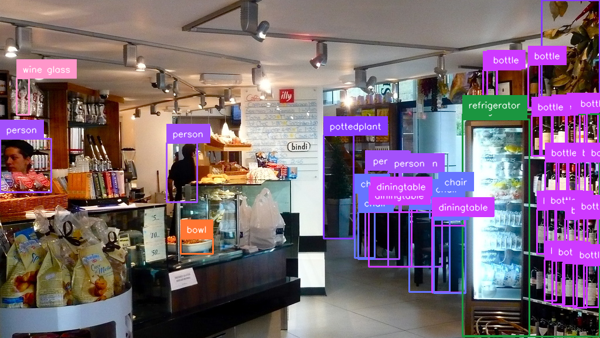

In [6]:
# display result without NMS
detections = sv.Detections.from_transformers (results [0])
labels = [
    model.config.id2label [class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator ().annotate (annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image

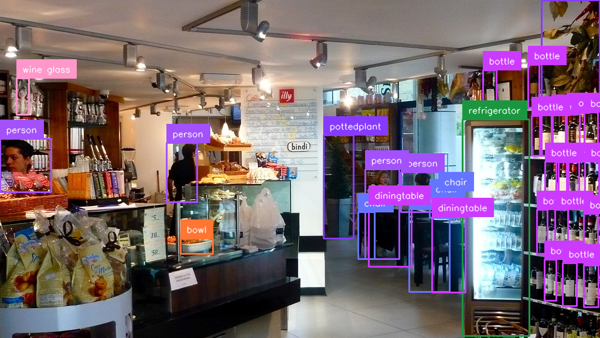

In [7]:
# display result without NMS
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]
annotated_image = image.copy()
annotated_image = sv.BoxAnnotator ().annotate (annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image

**Run inference with pre-trained Florence-2 model**

In [8]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [9]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [10]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


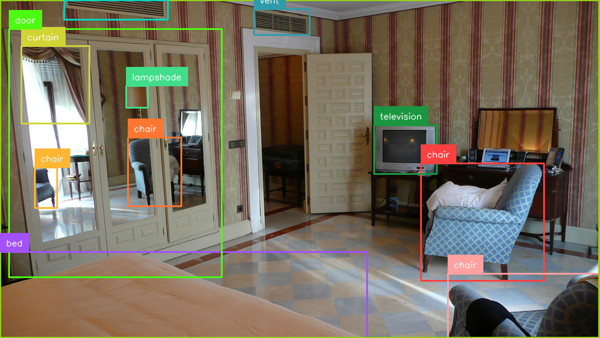

In [11]:
# example object detection inference
image = Image.open ('/kaggle/input/indoor-object-detection/train/images/0beb9cbe0c770abf.jpg')
task = "<OD>"
text = "<OD>"

inputs = processor (text = text, images = image, return_tensors = "pt").to(DEVICE)
generated_ids = model.generate (
    input_ids = inputs ["input_ids"],
    pixel_values = inputs ["pixel_values"],
    max_new_tokens = 1024,
    num_beams = 3
)
generated_text = processor.batch_decode (generated_ids, skip_special_tokens = False)[0]
response = processor.post_process_generation (generated_text, task = task, image_size = (image.width, image.height))
detections = sv.Detections.from_lmm (sv.LMM.FLORENCE_2, response, resolution_wh = image.size)

bounding_box_annotator = sv.BoxAnnotator (color_lookup = sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator (color_lookup = sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate (image, detections)
image = label_annotator.annotate (image, detections)
image.thumbnail ((600, 600))
image